In [66]:
%matplotlib inline
from qiskit import *
from qiskit import IBMQ, transpile
from qiskit import QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
import numpy as np
import matplotlib.pyplot as plt

In [67]:
def h_Z(qc,h,dt):
    for i in range(5):
        if i==0 or i==4:
            qc.rz(h*dt,i)
        else:
            qc.rz(2*h*dt,i)
        
def X_Rabi(qc,Omega,dt): # Rabi coupling
    
    for i in range(5):
        
        qc.rx(2*Omega*dt,i)
        
def ZZ(qc,V,dt): # nearest neighbor coupling
    
    qc.cx(0,1)
    
    qc.rz(-2*V*dt,1)
    
    qc.cx(0,1)
    
    qc.cx(2,3)
    
    qc.rz(-2*V*dt,3)
    
    qc.cx(2,3)
    
    qc.cx(1,2)
    
    qc.rz(-2*V*dt,2)
    
    qc.cx(1,2)
    
    qc.cx(3,4)
    
    qc.rz(-2*V*dt,4)
    
    qc.cx(3,4)

def Trotter_circuit_5_site(h,Omega,V,T,n):
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(5)
        
        ### Initial state setting
        
        Trotter_circuit.x(1)
        
        Trotter_circuit.x(3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            X_Rabi(Trotter_circuit,Omega,dt) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt) # Z field 
            
            ZZ(Trotter_circuit,V,dt) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        Trotter_circuit.measure_all()
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

In [68]:
Omega = 0.2*2

h = 2*2

V = 1*2

T = 10 # Total time

TT=T

n = 20

NN=n

Trotter_circuit = Trotter_circuit_5_site(h,Omega,V,T,n)

In [69]:
ideal_sim = Aer.get_backend('qasm_simulator')

result = ideal_sim.run(transpile(Trotter_circuit, ideal_sim)).result()

#sim_sant = AerSimulator.from_backend(device_backend)

In [70]:
shots = 8192

il = [0,1,2,3,4]

Trotter_circuit_sim = execute(Trotter_circuit, ideal_sim, shots=shots, initial_layout=il)

result_sim_noise=Trotter_circuit_sim.result()

In [71]:
Sz_sim_noise = []
for i in range(NN):
    tot_sim=np.zeros(5)
    Result_sim_noise = result_sim_noise.get_counts(i) 
    for j in range(2**5):
        n=2**5
        if j in Result_sim_noise.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_sim+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_sim_noise.int_outcomes()[j] 
    Sz_sim_noise.append(tot_sim/shots)
Sz_sim_noise=np.array(Sz_sim_noise)

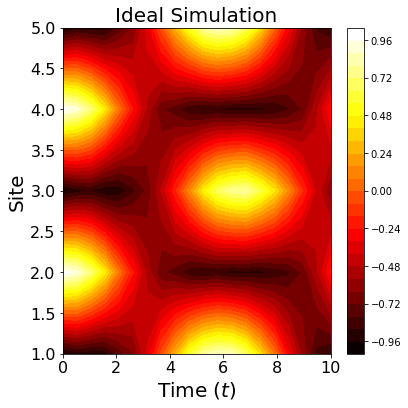

In [72]:
t=np.linspace(0,T,NN)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_sim_noise), 30, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)

ax.set_ylabel('Site', fontsize =20)
ax.set_xlabel('Time $(t)$', fontsize =20)

plt.title('Ideal Simulation', fontsize = 20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [73]:
from qiskit.test.mock import FakeSantiago

provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_santiago')
noise_model = NoiseModel.from_backend(backend)

sim_sant = AerSimulator.from_backend(backend)

ibmqfactory.load_account:WARNING:2021-06-03 14:13:36,904: Credentials are already in use. The existing account in the session will be replaced.


In [74]:
shots = 8192

il = [0,1,2,3,4]

trotter_transpile = transpile(Trotter_circuit, sim_sant)

Trotter_circuit_sim = execute(trotter_transpile, sim_sant, shots=shots, initial_layout=il,
                              noise_model=noise_model)

result_sim_noise=Trotter_circuit_sim.result()

In [75]:
Sz_sim_noise = []
for i in range(NN):
    tot_sim=np.zeros(5)
    Result_sim_noise = result_sim_noise.get_counts(i) 
    for j in range(2**5):
        n=2**5
        if j in Result_sim_noise.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_sim+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_sim_noise.int_outcomes()[j] 
    Sz_sim_noise.append(tot_sim/shots)
Sz_sim_noise=np.array(Sz_sim_noise)

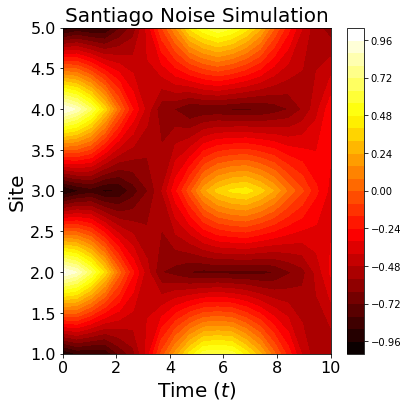

In [76]:
t=np.linspace(0,T,NN)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_sim_noise), 30, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)

ax.set_ylabel('Site', fontsize =20)
ax.set_xlabel('Time $(t)$', fontsize =20)

plt.title('Santiago Noise Simulation', fontsize = 20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [77]:
noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'operations': ['id'],
   'instructions': [[{'name': 'kraus',
      'qubits': [0],
      'params': [array([[-0.99992304+0.j,  0.        +0.j],
              [ 0.        +0.j, -0.99979984+0.j]]),
       array([[-0.00878313+0.j,  0.        +0.j],
              [ 0.        +0.j,  0.00878421+0.j]]),
       array([[0.        +0.j, 0.        +0.j],
              [0.00876227+0.j, 0.        +0.j]]),
       array([[0.        +0.j, 0.01797537+0.j],
              [0.        +0.j, 0.        +0.j]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [[0]]},
  {'type': 'qerror',
   'operations': ['id'],
   'instructions': [[{'name': 'x', 'qubits': [0]}],
    [{'name': 'x', 'qubits': [0]}, {'name': 'z', 'qubits': [0]}],
    [{'name': 'x', 'qubits': [0]}, {'name': 'reset', 'qubits': [0]}],
    [{'name': 'y', 'qubits': [0]}],
    [{'name': 'y', 'qubits': [0]}, {'name': 'z', 'qubits': [0]}],
    [{'name': 'y', 'qubits': [0]}, {'name': 'reset', 'qubits': [0]}],
    [{'name

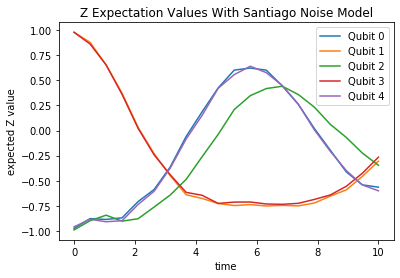

In [78]:
fig,ax = plt.subplots()
ax.plot(t, Sz_sim_noise[:,0], label='Qubit 0')
ax.plot(t, Sz_sim_noise[:,1], label='Qubit 1')
ax.plot(t, Sz_sim_noise[:,2], label='Qubit 2')
ax.plot(t, Sz_sim_noise[:,3], label='Qubit 3')
ax.plot(t, Sz_sim_noise[:,4], label='Qubit 4')
ax.set_xlabel('time')
ax.set_ylabel('expected Z value')
ax.set_title("Z Expectation Values With Santiago Noise Model")
ax.legend()